In [35]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import r2_score 

In [2]:
#read data from txt file
years = range(2011, 2017)
files = ['CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in years]
usecols = [1,2,8]

data = [np.loadtxt(f, usecols=usecols) for f in files]
data = np.vstack(data)
data = pd.DataFrame(data)
data = data.rename(columns = {0:'time', 1:'minute', 2:'temp'})
data

,time,minute,temp
0,20110101.0,5.0,-6.4
1,20110101.0,10.0,-6.5
2,20110101.0,15.0,-6.5
3,20110101.0,20.0,-6.5
4,20110101.0,25.0,-6.7
...,...,...,...
631291,20161231.0,2340.0,0.3
631292,20161231.0,2345.0,0.2
631293,20161231.0,2350.0,0.0
631294,20161231.0,2355.0,-0.1


In [3]:
#rename table
data = data.rename(columns = {0:'time', 1:'hour', 2:'temp'})
data

,time,minute,temp
0,20110101.0,5.0,-6.4
1,20110101.0,10.0,-6.5
2,20110101.0,15.0,-6.5
3,20110101.0,20.0,-6.5
4,20110101.0,25.0,-6.7
...,...,...,...
631291,20161231.0,2340.0,0.3
631292,20161231.0,2345.0,0.2
631293,20161231.0,2350.0,0.0
631294,20161231.0,2355.0,-0.1


In [4]:
#split 'time' column to year, month and date
data['year'] = data.time.apply(lambda x: int(str(x)[:4]))
data['month'] = data.time.apply(lambda x: int(str(x)[4:6]))
data['date'] = data.time.apply(lambda x: int(str(x)[6:8]))
data

,time,minute,temp,year,month,date
0,20110101.0,5.0,-6.4,2011,1,1
1,20110101.0,10.0,-6.5,2011,1,1
2,20110101.0,15.0,-6.5,2011,1,1
3,20110101.0,20.0,-6.5,2011,1,1
4,20110101.0,25.0,-6.7,2011,1,1
...,...,...,...,...,...,...
631291,20161231.0,2340.0,0.3,2016,12,31
631292,20161231.0,2345.0,0.2,2016,12,31
631293,20161231.0,2350.0,0.0,2016,12,31
631294,20161231.0,2355.0,-0.1,2016,12,31


In [5]:
# Function convert a date to its order in a year
from datetime import datetime
from datetime import date
def get_date_dif(d1,d2):
    a = str(int(d1[0]))+'-'+str(int(d1[1]))+'-'+ str(int(d1[2]))
    b = str(int(d2[0]))+'-'+str(int(d2[1]))+'-'+ str(int(d2[2]))

    a = datetime.strptime(a, "%Y-%m-%d")
    b = datetime.strptime(b, "%Y-%m-%d")
    return abs((a - b).days) + 1
get_date_dif([2013,1,1], [2013,3,1])

60

In [6]:
#apply the model on the data frame
data['days_dif'] = data.apply(lambda x: get_date_dif([x.year,x.month,x.date],[x.year,1,1]), axis=1)

In [7]:
#convert hour to minute
def to_min(x):
    hour = x//100
    mins = x%100
    return(hour*60+mins)
to_min(2300)

1380

In [10]:
data['mins'] = data.hour.apply(lambda x: to_min(x))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
data = data[data.temp>-1000]
train_data = data[data.year < 2016][['mins','days_dif','temp']]
test_data = data[data.year >= 2016][['mins','days_dif','temp']]



In [12]:
X_train = train_data[['mins','days_dif']]
y_train =train_data['temp']
X_test = test_data[['mins','days_dif']]
y_test = test_data['temp']
X_train

,mins,days_dif
0,5.0,1
1,10.0,1
2,15.0,1
3,20.0,1
4,25.0,1
...,...,...
525882,1415.0,365
525883,1420.0,365
525884,1425.0,365
525885,1430.0,365


<b>Note: </b>Although I tried different numbers of radial basis functions and different widths of the radial basis function, for the sake of the presentation, I only present values that produce the best result.

# using both mins and days_dif as predictors

In [47]:
#The best values of of centers I found is 288
#There are 24 centers for the 'mins' input that corresspond to 24 hours in a day
# and 12 centers of 'days_dif' input (12 months in a year))
#In total we have 24*12 = 288 centers for the model
centers = []
for i in range(30,1440,60):
    for j in range(0,365,31):
        centers.append([i,j])
centers = np.array(centers)

centers.shape

(288, 2)

In [49]:
#high sigma means more flexibility in the model, which allows the model to fits the data better.
sigma = 10000
alpha = 0.1

#apply rbf for train data
expanded_X_train = rbf_kernel(X_train, centers, gamma= 1/sigma)
expanded_X_train

#create a linear regression model
regr = LinearRegression()
regr.fit(expanded_X_train, y_train)




LinearRegression()

Score on test data =  0.6230067100030776


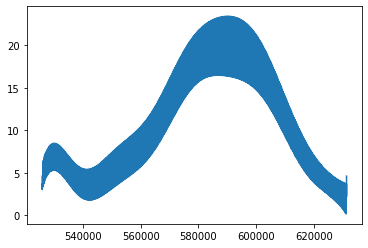

In [54]:

#use the model to predict the training data
expanded_X_test = rbf_kernel(X_test, centers, gamma= 1/sigma)
prediction = regr.predict(expanded_X_test)
plt.plot(X_test.index, prediction)

print("Score on test data = ", r2_score(y_test,prediction))

Text(0.5, 1.0, 'time of a year contribution totemperature')

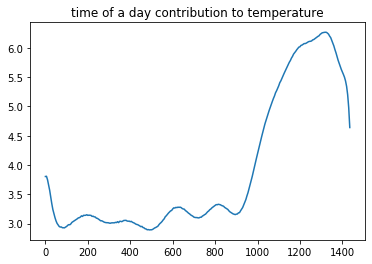

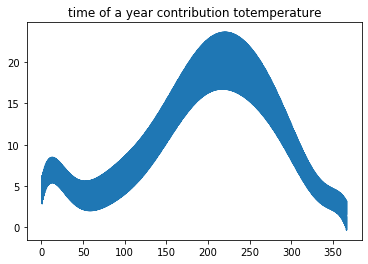

In [24]:
#use the model to predict the training data
expanded_x_test = rbf_kernel(X_test, centers, gamma= 1/sigma)
prediction = regr.predict(expanded_x_test)
plt.figure()
plt.plot(X_test.mins[:288], prediction[:288])
plt.title('time of a day contribution to temperature')
plt.figure()
plt.plot(X_test.days_dif[:-1], prediction[:-1])
plt.title('time of a year contribution totemperature')

# Using time of a day (mins) as predictor

In [55]:
centers = np.array(range(30,1440,60)).reshape(-1,1)

sigma = 10000
alpha = 0.1

#apply rbf for train data
expanded_X_train = rbf_kernel(np.array(X_train.mins).reshape(-1,1), centers, gamma= 1/sigma)
expanded_X_train

#create a linear regression model
regr = LinearRegression()
regr.fit(expanded_X_train, y_train)

#test the model on test set
expanded_X_test = rbf_kernel(np.array(X_test.mins).reshape(-1,1), centers, gamma= 1/sigma)
prediction = regr.predict(expanded_X_test)
print("Score on test data = ", r2_score(y_test,prediction))



Score on test data =  0.044278598615585474


# Using time of a year (days_dif) as predictor

In [57]:
centers = np.array(range(1,366,31)).reshape(-1,1)

sigma = 10000
alpha = 0.1

#apply rbf for train data
expanded_X_train = rbf_kernel(np.array(X_train.days_dif).reshape(-1,1), centers, gamma= 1/sigma)
expanded_X_train

#create a linear regression model
regr = LinearRegression()
regr.fit(expanded_X_train, y_train)

#test the model on test set
expanded_X_test = rbf_kernel(np.array(X_test.days_dif).reshape(-1,1), centers, gamma= 1/sigma)
prediction = regr.predict(expanded_X_test)
print("Score on test data = ", r2_score(y_test,prediction))





Score on test data =  0.5717257164127173


<b>Conclusion:</b> The model that combines both time of day and time of a year as inputs yield the highest R^2 (.623). This makes sense in reality as the temperature varies in day (i.e. tends to be hottest at noon) and in year (i.e. tends to be hottest in the summer)